In [1]:
import numpy as np
import scipy
from scipy import signal
import soundfile as sf
import struct
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib tk

numerator: [ 1. -1.]; Denominator: [ 1.         -0.99951172]. 


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


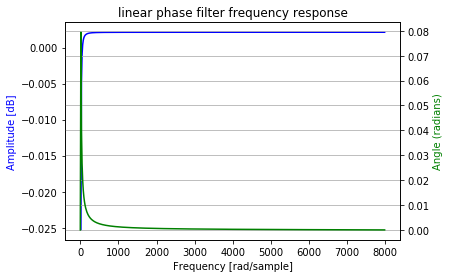

In [6]:
HP_Gain = -11

filtNumer = np.array([1., -1.], dtype=float)

filtDenom = np.array([1, -(1-2**HP_Gain)], dtype=float)

print('numerator: {}; Denominator: {}. '.format(filtNumer, filtDenom))

w, h = signal.freqz(filtNumer, filtDenom, fs=16000)

fig, ax1 = plt.subplots()
ax1.set_title('linear phase filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()



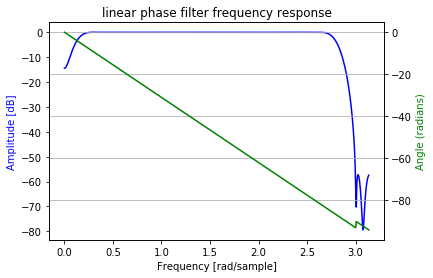

In [128]:
# we use linear phase filter to keep the shape of waveform
numtaps = 63
f1, f2 = 0.03, 0.9
par_fir=signal.firwin(numtaps, [f1, f2], pass_zero=False)
w, h = signal.freqz(par_fir,[1])

fig, ax1 = plt.subplots()
ax1.set_title('linear phase filter frequency response')
ax1.plot(w, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [rad/sample]')
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()

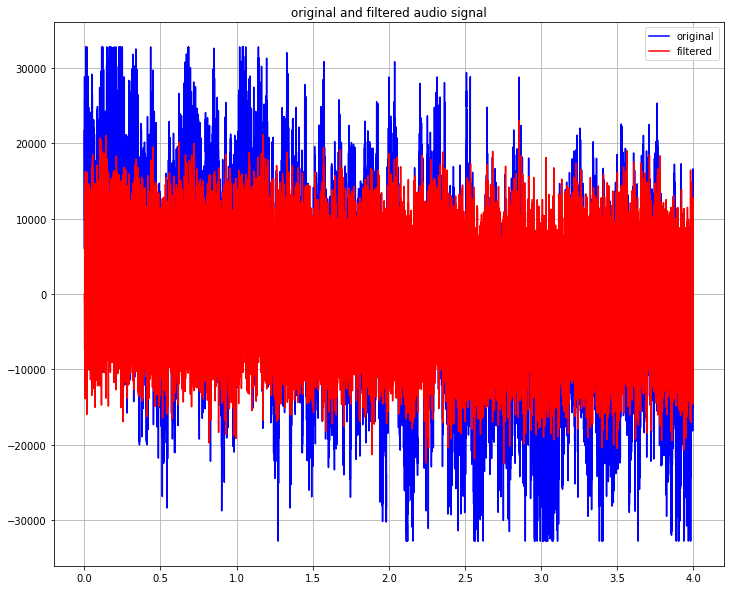

In [129]:
Fs = 16000
Duration = 4

pinkNoise_xS, _ = sf.read("/Users/axel/KWS/audio/speech_dataset_v0_01/_background_noise_/pink_noise.wav", \
                           stop=Fs*Duration, dtype='int16') 
output_fir = signal.lfilter(par_fir, [1], pinkNoise_xS)

t = np.linspace(0, Duration, Fs*Duration)

fig = plt.figure(figsize=(12,10))
plt.title("original and filtered audio signal")
plt.plot(t, pinkNoise_xS, 'b')
plt.plot(t, output_fir, 'r')
plt.legend(('original', 'filtered'), loc='best')
plt.grid(True)
plt.show()

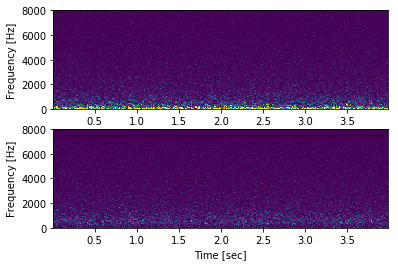

In [130]:
f, t_f, SpxPinkNoise = signal.spectrogram(pinkNoise_xS, Fs)
f, t_f, SpxOutputFir = signal.spectrogram(output_fir, Fs)

plt.subplot(2, 1, 1)
plt.pcolormesh(t_f, f, SpxPinkNoise, vmin=0, vmax=np.max(SpxOutputFir))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(2, 1, 2)
plt.pcolormesh(t_f, f, SpxOutputFir, vmin=0, vmax=np.max(SpxOutputFir))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [131]:
# We generate a test wav with pink noise background
DampFactor = 0.03
origWav, _ = sf.read("/Users/axel/KWS/audio/experiment/Alexa_P09_05.wav", dtype='int16')
noisedWav = []
noiseAug, _ = sf.read('/Users/axel/KWS/audio/speech_dataset_v0_01/_background_noise_/pink_noise.wav',\
                     dtype='int16')
noiseLen = len(noiseAug)
for indx, wave in enumerate(origWav):
    wave += noiseAug[(indx%noiseLen)]*DampFactor
    noisedWav.append(wave)
noisedWav = np.array(noisedWav, dtype='int16')
sf.write("/Users/axel/KWS/audio/experiment/Alexa_P09_05_noised.wav", noisedWav, Fs)

filteredWav = signal.lfilter(par_fir, [1], noisedWav)
filteredWav = np.array(filteredWav, dtype='int16')
sf.write("/Users/axel/KWS/audio/experiment/Alexa_P09_05_filtered.wav", filteredWav, Fs)

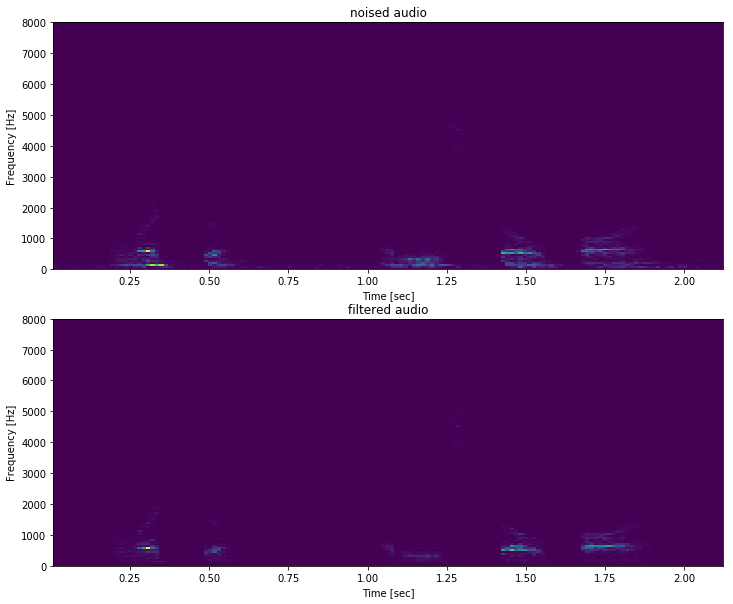

In [132]:
f, t_f, SpxnoisedWav = signal.spectrogram(noisedWav, Fs)
f, t_f, SpxfilteredWav = signal.spectrogram(filteredWav, Fs)

fig = plt.figure(figsize=(12,10))
plt.subplot(2, 1, 1)
plt.title("noised audio")
plt.pcolormesh(t_f, f, SpxnoisedWav, vmin=0, vmax=np.max(SpxfilteredWav))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

plt.subplot(2, 1, 2)
plt.title("filtered audio")
plt.pcolormesh(t_f, f, SpxfilteredWav, vmin=0, vmax=np.max(SpxfilteredWav))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

# system prameters
Fs = 16000.
Channels = 2
Hop = 80
Wlen = 128
Nfft = 1*Wlen

audioDataPath = "./audio_data/pcm_record_data_AS_0.bin"

binData = open(audioDataPath, 'rb').read()

dataParse = DataLoader(Wlen*4, Hop*4, data_packed=True, 
                       audio_channels=2, channel_swap=False)
signalChain = SignalProcessor(Fs, Hop, Wlen, Nfft, anal_window="hann", 
                              synth_window="hann")

#loading beamformer from external .csv file
maxsnr_bformer = beamformer()
maxsnr_bformer.load(load_path='./beamforming/weights/weights_2cm_AWE.csv')
#mvdr_bformer = beamformer()
#mvdr_bformer.load(load_path='./beamforming/weights/weights_2cm_MVDR_T180.csv')

left_wav_data, right_wav_data = dataParse.pcm_data_to_wav_float(binData) 

fig = plt.figure(figsize=(12,9))
plt.plot(right_wav_data, label='right')
plt.plot(left_wav_data, label='left')
plt.legend()
plt.title('Left and Right channel Data')
plt.show()


#run with maxsnr beamformer

left_stft, freq, time = signalChain.stft(left_wav_data)

right_stft, freq, time =signalChain.stft(right_wav_data)

left_beam_stft = np.zeros(shape=np.shape(left_stft), dtype=complex).T
right_beam_stft = np.zeros(shape=np.shape(right_stft), dtype=complex).T

for indx in range(np.shape(left_stft)[-1]):
    left_beam_stft[indx] = left_stft.T[indx] * maxsnr_bformer.params[0]
    right_beam_stft[indx] = right_stft.T[indx] * maxsnr_bformer.params[1]

left_stft_filtered = left_beam_stft.T
right_stft_filtered = right_beam_stft.T

Y = left_stft_filtered + right_stft_filtered

audio_formed_maxsnr, t = signalChain.istft(Y)

#run with mvdr beamformer
left_stft, freq, time = signalChain.stft(left_wav_data)

right_stft, freq, time =signalChain.stft(right_wav_data)

left_beam_stft = np.zeros(shape=np.shape(left_stft), dtype=complex).T
right_beam_stft = np.zeros(shape=np.shape(right_stft), dtype=complex).T

for indx in range(np.shape(left_stft)[-1]):
    left_beam_stft[indx] = left_stft.T[indx] * mvdr_bformer.params[0]
    right_beam_stft[indx] = right_stft.T[indx] * mvdr_bformer.params[1]

left_stft_filtered = left_beam_stft.T
right_stft_filtered = right_beam_stft.T

Y = left_stft_filtered + right_stft_filtered

audio_formed_mvdr, t = signalChain.istft(Y)

# comparison between maxsnr and mvdr

plt.figure(figsize=(12,9))
plt.plot(audio_formed_maxsnr, label='maxsnr')
plt.plot(right_wav_data, label='right')

#plt.plot(audio_formed_mvdr, label='mvdr')
plt.plot(left_wav_data, label='left')

plt.legend()
plt.title('left channel beamforming performance')
plt.show()